# 04-AlexNet and GoogLeNet

In this lab, we will develop PyTorch implementations of AlexNet and GoogleLeNet from scratch and compare them on CIFAR-10.

## Re-run the important words

**Tensor** - any matrix arrays which use for calculation, you can call input, output, weight as any tensors. In CNNs, we use "input tensor" as input; i.e. image, and "output tensor" as output.

**Kernel** - filter tensor, or weight tensor. In computer vision, we might call mask tensor or mask matrix.

**Channel** - number of depth in tensor, so sometime we call **depth**.

**Feature** - Specific characteristic information for using in **dense layers** or **fully connect layers**.

**Feature extraction** - the process of transforming raw data into numerical features that can be processed while preserving the information in the original data set.

**Stride** - The jump necessary to go from one element to the next one in the specified dimension dim . A tuple of all strides is returned when no argument is passed in.

**Padding** - the zero array extends in both sides of tensor.


In PyTorch, the function of CNNs is no need to input size, but it needs to fill number of channels and kernel size, including operation in the layer. For dense layer or fully layer, we need to set input features number and output features number. Thus, it is necessary to understand how to calculate tensors and features size in each layer.

## Re-run output tensors size

If we have an input tensor or image input size $w \times h$ which want to convolution with $k_w \times k_h$ kernel size with padding $p$ and stride $s$, we can calculate output tensor size as:

$$output_{size}=\lfloor \frac{w+2p-k_w}{s} + 1 \rfloor \times \lfloor \frac{h+2p-k_h}{s} + 1 \rfloor $$

For example, input image in the first layer is $224 \times 224$. Using $11 \times 11$ of kernel size with padding $2$ and stride 4. We calculate

$$output_{size}=\lfloor \frac{w+2p-k_w}{s} + 1 \rfloor = \lfloor \frac{224+2(2)-11}{4} + 1 \rfloor = \lfloor 55.25 \rfloor = 55$$

## AlexNet programing

From class, we now know that the AlexNet model (1 machine) looks like this:

<img src="img/alexnet.png" title="AlexNet (Alex et al.)" style="width: 900px;" />

## Coding in PyTorch

First, we import some necessary libraries:

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F

### Setup dataset

Next, we set up Dataset objects and DataLoader objects to load images, transform them to 3x224x224, and batch them for training/testing:

In [2]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')

    # Your root path in gdrive
    root_path = 'gdrive/My Drive/'
else:
    root_path = './'

In [3]:
import os
os.environ['http_proxy'] = "http://squid.cs.ait.ac.th:3128/"
os.environ['https_proxy'] = "http://squid.cs.ait.ac.th:3128/"

In [10]:
# !pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu116 --user

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     |████████████████████████████████| 1977.9 MB 586 bytes/s             |████████████████████            | 1240.6 MB 639 kB/s eta 0:19:14MB 808 kB/s eta 0:10:04
     |████████████████████████████████| 24.2 MB 65 kB/s              
     |████████████████████████████████| 4.2 MB 38.4 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
torch.cuda.is_available()

True

In [5]:

# Set up preprocessing of CIFAR-10 images to 3x224x224 with normalization
# using the magic ImageNet means and standard deviations. You can try
# RandomCrop, RandomHorizontalFlip, etc. during training to obtain
# slightly better generalization.

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and split into training, validation, and test sets

train_dataset = torchvision.datasets.CIFAR10(root=root_path + 'data', train=True,
                                             download=True, transform=preprocess)

# Split the training set into training and validation sets randomly.
# CIFAR-10 train contains 50,000 examples, so let's split 80%/20%.

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

# Download the test set. If you use data augmentation transforms for the training set,
# you'll want to use a different transformer here.

test_dataset = torchvision.datasets.CIFAR10(root=root_path + 'data', train=False,
                                            download=True, transform=preprocess)

# Dataset objects are mainly designed for datasets that can't fit entirely into memory.
# Dataset objects don't load examples into memory until their __getitem__() method is
# called. For supervised learning datasets, __getitem__() normally returns a 2-tuple
# on each call. To make a Dataset object like this useful, we use a DataLoader object
# to optionally shuffle then batch the examples in each dataset. During training.
# To keep our memory utilization small, we'll use 4 images per batch, but we could use
# a much larger batch size on a dedicated GPU. To obtain optimal usage of the GPU, we
# would like to load the examples for the next batch while the current batch is being
# used for training. DataLoader handles this by spawining "worker" threads that proactively
# fetch the next batch in the background, enabling parallel training on the GPU and data
# loading/transforming/augmenting on the CPU. Here we use num_workers=2 (the default)
# so that two batches are always ready or being prepared.

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                              shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## "AlexNet" Using the Module API

The Sequential API makes it easy to create a sequential model, but not all models are sequential. For example, we need more flexibility
to create a complex model such as GoogLeNet.

Working with the `Module` API requires us to use object-oriented inheritance in Python. This means you'll have to brush up on your OO concepts or learn the basics if OOP is new to you.

We create a new class that inherits from `Module`, then in most cases, we just need to override two methods: `__init__()` and `forward()`.

`__init__()` is called the "constructor" of a class and is the method called on any Python object just after it is created, similar to constructors in Java or C++.

However, constructors and instance methods work a little differently in Python than they do in Java or C++. The constructor is just an ordinary instance method that is only special in that it
is called implicitly when the object is created. Instance methods in Python (methods called on an object) are distinguished from class methods (methods called on the class, not requiring any
instance) by the presence or absence of the `self` keyword in the parameter list. In the body of an instance method, `self` is a reference to the instance the method was called on, same as
`this` in Java or C++ or `self` in Ruby.

Anther difference between Python and other languages is that object initialization in an inheritance hierarchy is more flexible.
A constructor should normally call `super(ClassName, self).__init__()` (Python 2, also works in Python 3) or `super().__init__()` (Python 3 only) at the beginning of its
own `__init__()` method to initialze any fields used by methods in the superclass, but it need not do so.

In the case of a PyTorch `Module` subclass, we should call `super()` before doing other things.

The `forward()` method is also an instance method that is implicitly called when we invoke a `Module` instance as a function. So the code

    module = MyModule()
    
creates an instance of `MyModule` and then calls its `__init__()` method, whereas

    outputs = module(inputs)

invokes the `forward()` method defined in `MyModule`.

### The model

Here's an implementation of an AlexNet-like network.

Note that `Sequential` is itself a subclass of `Module`. This means we can use `Sequential` for a sequential flow in a larger network.

Also note that the adaptive average pool layer between the feature module and the classifier is a trick used to ensure a fixed set of 6x6 feature maps come out
of the feature extractor regardless of the input image size. It is not strictly required here (and not used in the original paper) but would allow us to use other input sizes besides 224x224 if we like.


In [6]:
class AlexNetModule(nn.Module):
    '''
    An AlexNet-like CNN

    Attributes
    ----------
    num_classes : int
        Number of classes in the final multinomial output layer
    features : Sequential
        The feature extraction portion of the network
    avgpool : AdaptiveAvgPool2d
        Convert the final feature layer to 6x6 feature maps by average pooling if they are not already 6x6
    classifier : Sequential
        Classify the feature maps into num_classes classes
    '''
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Next, we set up to execute on a particular GPU or the CPU only:

In [7]:
# cuda, or cuda:0 means using GPU slot 0.
# If there are more than 1 GPUs, you can select other GPUs using cuda:1, cuda:2, ...
# In terminal (Linux), you can check memory using in each GPU by using command
# $ nvidia-smi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cuda:0


Then, create the model from <code>AlexNetModule</code> class.

In [8]:
alexnet = AlexNetModule(10)
alexnet = alexnet.to(device)

### Training function

Next, let's write a function to train our model for some number of epochs. This one is adapted from the PyTorch tutorials.

In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model function

    Train a PyTorch model for a given number of epochs.
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the train/validation dataset according to which phase we're in
            
            for inputs, labels in dataloaders[phase]:

                # Inputs is one batch of input images, and labels is a corresponding vector of integers
                # labeling each image in the batch. First, we move these tensors to our target device.
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out any parameter gradients that have previously been calculated. Parameter
                # gradients accumulate over as many backward() passes as we let them, so they need
                # to be zeroed out after each optimizer step.

                optimizer.zero_grad()

                # Instruct PyTorch to track gradients only if this is the training phase, then run the
                # forward propagation and optionally the backward propagation step for this iteration.

                with torch.set_grad_enabled(phase == 'train'):
                    # The inception model is a special case during training because it has an auxiliary
                    # output used to encourage discriminative representations in the deeper feature maps.
                    # We need to calculate loss for both outputs. Otherwise, we have a single output to
                    # calculate the loss on.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backpropagate only if in training phase

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Gather our summary statistics
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # If this is the best model on the validation set so far, deep copy it

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    # Output summary statistics, load the best weight set, and return results
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

### Optimizer and loss function

Before we start training, we need to set up an optimizer object and a loss function. Typical choices for the loss function:
* For regression problems, use `nn.MSELoss()`. The equation is:
$$MSE=\frac{1}{N}\sum_{i=1}^N(y_i-\hat{y}_i)^2 $$
* For binary classification, use `nn.BCELoss()`
$$BCE=-\frac{1}{N}\sum_{i=1}^N y_i\cdot \log{\hat{y}_i} + (1-y_i)\cdot \log(1 -{\hat{y}_i})$$
* For multinomial classification, use `nn.CrossEntropyLoss()`
$$CE=-\sum_{i=1}^C t_i\cdot \log(f(s)_i)$$
where $t_i$ and $s_i$ are the groundtruth and the CNN score for each class $i$ in $C$.  An activation function (Sigmoid / Softmax) is usually applied to the scores before the CE Loss computation, so $f(s)_i$ to refer to the activations.
* For specialized needs, define your own loss function!

Typical choices for the optimizer:
* SGD: Scholastic gradient descent, works well for most cases but requires appropriate values for the learning, momentum, and weight decay. Given $\alpha$ is learning rate, and $\beta$ is momentum, the equation is

$$V_t = \beta V_{t-1} + (1-\beta)\nabla_wL(W,X,y)$$
$$W_{t+1} = W_t + \alpha V_t$$

 for more information please see [Stochastic Gradient Descent with momentum](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d)

* Adam: adaptive learning rate optimizer that usually gives superior results to SGD but sometimes doesn't work. Adam's equation is:
$$(m_t)_i=\beta_1(m_{t-1})_i+(1-\beta_1)(\nabla(W_t))_i,$$
$$(v_t)_i=\beta_2(v_{t-1})_i+(1-\beta_2)(\nabla(W_t))_i^2,$$
$$(W_{t+1})i=(W_t)_i-\alpha\frac{\sqrt{1-(\beta_2)_i^t}}{1-(\beta_i)_i^t}\frac{(m_t)_i}{\sqrt{(v_t)_i}+\epsilon}$$
* See the many other choices selected from recent deep learning papers in the [PyTorch optim documentation](https://pytorch.org/docs/stable/optim.html).


In [10]:
# Using CrossEntropyLoss for multinomial classification (Because we have 10 classes)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = alexnet.parameters()
# Use scholastic gradient descent for update weights in model with learning rate 0.001 and momentum 0.9
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

## Training the model

Use train_model function for training.

In [11]:
dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

best_model, val_acc_history, loss_acc_history = train_model(alexnet, dataloaders, criterion, optimizer, 10, 'alex_sequential_lr_0.001_bestsofar')

Epoch 0/9
----------
train Loss: 1.7741 Acc: 0.3367
Epoch time taken:  122.57512998580933
val Loss: 1.4114 Acc: 0.4981
Epoch time taken:  135.2448446750641

Epoch 1/9
----------
train Loss: 1.2454 Acc: 0.5556
Epoch time taken:  113.03743958473206
val Loss: 1.1041 Acc: 0.6032
Epoch time taken:  126.34940505027771

Epoch 2/9
----------
train Loss: 0.9846 Acc: 0.6569
Epoch time taken:  114.461266040802
val Loss: 0.9120 Acc: 0.6854
Epoch time taken:  127.32296633720398

Epoch 3/9
----------
train Loss: 0.8447 Acc: 0.7071
Epoch time taken:  113.54925751686096
val Loss: 0.8114 Acc: 0.7179
Epoch time taken:  126.19178485870361

Epoch 4/9
----------
train Loss: 0.7339 Acc: 0.7462
Epoch time taken:  115.81947779655457
val Loss: 0.7409 Acc: 0.7440
Epoch time taken:  129.128160238266

Epoch 5/9
----------
train Loss: 0.6464 Acc: 0.7767
Epoch time taken:  117.42910742759705
val Loss: 0.7038 Acc: 0.7624
Epoch time taken:  130.5858063697815

Epoch 6/9
----------
train Loss: 0.5732 Acc: 0.8005
Epoch 

### Plot results

Based on these results, let's plot the validation loss/accuracy curves:

In [12]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history):
    plt.plot(loss_acc_history, label = 'Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'Validation')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

In [13]:
val_acc_history = [val.cpu() for val in val_acc_history]

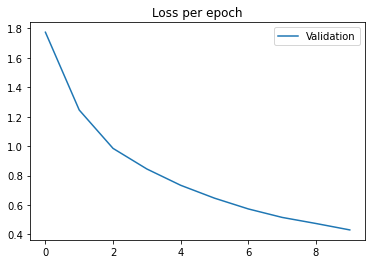

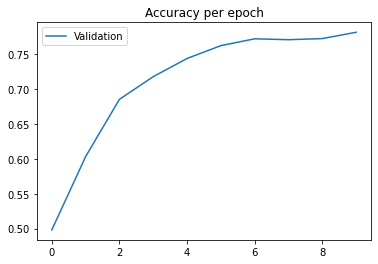

In [14]:
plot_data(val_acc_history, loss_acc_history)

## GoogleLeNet

Next, we'd like to construct GoogLeNet as described in the [original GoogLeNet paper](https://arxiv.org/abs/1409.4842) from scratch.

This part of the lab is adapted from [kuangliu's PyTorch CIFAR repository on GitHub](https://github.com/kuangliu/pytorch-cifar/blob/master/models/googlenet.py).

### GoogleLeNet

GoogleLeNet or Inception network is an important concept for development CNN classifier. Most of CNNs just stacked convolution deeper and deeper to get performance, but very deep networks are prone to overfitting. It also hard to pass gradient updates through the entire network, and make computation expensive. In the other hands, inception network do in wider path to improve performance.

<img src="img/expandDeeper.jpg" style="width: 400px;" />

There are several versions of the inception networks such as Inception v1, Inception v2, Inception v3, Inception v4, and Inception-ResNet.

The full architecture of GoogLeNet (inception1) looks like this:

<img src="img/GoogleLeNet.png" style="width: 1080px;" />

### Inception block

The key innovation introduced by GoogLeNet is the concept of the "inception" block. A standard inception block looks like this:

<img src="img/inception.png" style="width: 600px;" />

### Auxiliary classifiers

To prevent the middle part of the network from “dying out”, the authors introduced two auxiliary classifiers (The purple boxes in the image). They essentially applied softmax to the outputs of two of the inception modules, and computed an auxiliary loss over the same labels. The total loss function is a weighted sum of the auxiliary loss and the real loss. Weight value used in the paper was 0.3 for each auxiliary loss.

$$ \mathcal{L}_{total} = \mathcal{L}_{Real} + 0.3 \mathcal{L}_{aux_1} + 0.3 \mathcal{L}_{aux_2}$$

### Inception v1 coding

Let's implement the architecture. 
Take a look at each element and see how it implements the concepts described in the paper.
First, we begin with a `Module` for an inception block with parameters that can be customized to implement each block in the overall network.


In [15]:
class Inception(nn.Module):
    '''
    Inception block for a GoogLeNet-like CNN

    Attributes
    ----------
    in_planes : int
        Number of input feature maps
    n1x1 : int
        Number of direct 1x1 convolutions
    n3x3red : int
        Number of 1x1 reductions before the 3x3 convolutions
    n3x3 : int
        Number of 3x3 convolutions
    n5x5red : int
        Number of 1x1 reductions before the 5x5 convolutions
    n5x5 : int
        Number of 5x5 convolutions
    pool_planes : int
        Number of 1x1 convolutions after 3x3 max pooling
    b1 : Sequential
        First branch (direct 1x1 convolutions)
    b2 : Sequential
        Second branch (reduction then 3x3 convolutions)
    b3 : Sequential
        Third branch (reduction then 5x5 convolutions)
    b4 : Sequential
        Fourth branch (max pooling then reduction)
    '''
    
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        self.in_planes = in_planes
        self.n1x1 = n1x1
        self.n3x3red = n3x3red
        self.n3x3 = n3x3
        self.n5x5red = n5x5red
        self.n5x5 = n5x5
        self.pool_planes = pool_planes
        
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)


### The whole shebang

Now the whole shebang.

Note that kiangliu's version is intended for CIFAR-10, so it's assuming a small input image size (3x32x32). Also, there are no side classifiers.
In the exercises, you'll convert this to the ImageNet style 224x224 input.


In [16]:
class GoogLeNet(nn.Module):
    '''
    GoogLeNet-like CNN

    Attributes
    ----------
    pre_layers : Sequential
        Initial convolutional layer
    a3 : Inception
        First inception block
    b3 : Inception
        Second inception block
    maxpool : MaxPool2d
        Pooling layer after second inception block
    a4 : Inception
        Third inception block
    b4 : Inception
        Fourth inception block
    c4 : Inception
        Fifth inception block
    d4 : Inception
        Sixth inception block
    e4 : Inception
        Seventh inception block
    a5 : Inception
        Eighth inception block
    b5 : Inception
        Ninth inception block
    avgpool : AvgPool2d
        Average pool layer after final inception block
    linear : Linear
        Fully connected layer
    '''

    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        # in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes
        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Next, here are the Dataset and DataLoader objects from kiangliu. Notice the transforms may be more suitable for CIFAR-10 than the ImageNet transforms we implemented last week. But will they work as well?

In [17]:
# Preprocess inputs to 3x32x32 with CIFAR-specific normalization parameters

preprocess = transforms.Compose([
    transforms.Resize(36),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and set up train, validation, and test datasets with new preprocess object

train_dataset = torchvision.datasets.CIFAR10(root=root_path + 'data', train=True,
                                            download=True, transform=preprocess)

train_datset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

test_dataset = torchvision.datasets.CIFAR10(root=root_path + 'data', train=False,
                                            download=True, transform=preprocess)

# Create DataLoaders

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                             shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                              shuffle=False, num_workers=2)

dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

Files already downloaded and verified
Files already downloaded and verified


### Training GoogLeNet

In [18]:
googlenet = GoogLeNet().to(device)
criterion_3 = nn.CrossEntropyLoss()
params_to_update_3 = googlenet.parameters()
optimizer_3 = optim.Adam(params_to_update_3, lr=0.01)

best_model3, val_acc_history3, loss_acc_history3 = train_model(googlenet, dataloaders, criterion_3, optimizer_3, 25, 'googlenet_lr_0.01_bestsofar')

Epoch 0/24
----------
train Loss: 1.6871 Acc: 0.3757
Epoch time taken:  78.90002679824829
val Loss: 2.0317 Acc: 0.3902
Epoch time taken:  84.7464075088501

Epoch 1/24
----------
train Loss: 1.1278 Acc: 0.5937
Epoch time taken:  79.77125573158264
val Loss: 1.2578 Acc: 0.5656
Epoch time taken:  84.35245823860168

Epoch 2/24
----------
train Loss: 0.8255 Acc: 0.7088
Epoch time taken:  79.31143832206726
val Loss: 0.8157 Acc: 0.7074
Epoch time taken:  83.9953773021698

Epoch 3/24
----------
train Loss: 0.6768 Acc: 0.7649
Epoch time taken:  80.65743660926819
val Loss: 0.6277 Acc: 0.7813
Epoch time taken:  85.63806438446045

Epoch 4/24
----------
train Loss: 0.5637 Acc: 0.8034
Epoch time taken:  81.00338172912598
val Loss: 0.5686 Acc: 0.8023
Epoch time taken:  85.88264870643616

Epoch 5/24
----------
train Loss: 0.4886 Acc: 0.8288
Epoch time taken:  80.46601128578186
val Loss: 0.6311 Acc: 0.7748
Epoch time taken:  85.10017228126526

Epoch 6/24
----------
train Loss: 0.4263 Acc: 0.8521
Epoch t

In [22]:
val_acc_history3 = [data.cpu() for data in val_acc_history3]

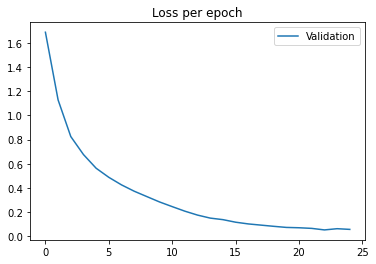

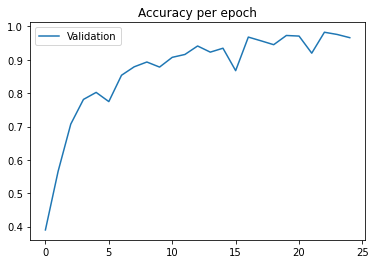

In [23]:
plot_data(val_acc_history3, loss_acc_history3)

## Exercises

1. Try to run the AlexNet and Inception net at above. Increase the number of epochs and show your accuracy/loss result. (50 points)

2. Please look at VGG model architecture for ImageNet dataset as below. Create your own VGG model for CIFAR-10 (the last layer is 10 output). Train the model, show your accuracy of test set, and plot your accuracy, loss of training per epoch. (25 points)
<img src="img/vgg16.png" title="VGG6" style="width: 900px;" />
3. Please look at inception net model as below. All modules can release the same output. Modify the inception model in to fig 6.5. Training and show your result. (25 points)

**Hint**: Just modify only inception class. Check conv2D function [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
<img src="img/fig9.png" title="Inception images" style="width: 600px;" />

The evolution of inception is below.
<img src="img/Inception v3.jpeg" title="Inception evolution" style="width: 900px;" />

#### You can read the paper in [here](https://arxiv.org/abs/1512.00567)

In [24]:
# Preprocess inputs to 3x32x32 with CIFAR-specific normalization parameters

preprocess = transforms.Compose([
    # transforms.Resize(227),
    # transforms.CenterCrop(224),
    transforms.Resize(36),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and set up train, validation, and test datasets with new preprocess object

train_dataset = torchvision.datasets.CIFAR10(root=root_path + 'data', train=True,
                                            download=True, transform=preprocess)

train_datset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

test_dataset = torchvision.datasets.CIFAR10(root=root_path + 'data', train=False,
                                            download=True, transform=preprocess)

# Create DataLoaders

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                             shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                              shuffle=False, num_workers=2)

dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

Files already downloaded and verified
Files already downloaded and verified


In [25]:
# VGG16 answer
# YOUR CODE HERE

class VGG_custom(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # 32 x 32 x 64
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2) # 16 x 16 x 64
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 16 x 16 x 128
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2) # 8 x 8 x 128

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 8 x 8 x 256
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2) # 4 x 4 x 256

        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # 4 x 4 x 512
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.maxpool4 = nn.MaxPool2d(2) # 2 x 2 x 512

        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.maxpool5 = nn.MaxPool2d(2) # 1 x 1 x 512

        # self.fc1 = nn.Linear(7 * 7 * 512, 4096)
        # self.fc2 = nn.Linear(4096, 4096)
        # self.fc3 = nn.Linear(4096, 1000)

        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.maxpool2(F.relu(self.conv4(x)))

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.maxpool3(F.relu(self.conv7(x)))

        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = self.maxpool4(F.relu(self.conv10(x)))

        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.maxpool5(F.relu(self.conv13(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    # 32 x 32 x 3

    #     self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # 32 - 3
    #     self.relu1 = nn.ReLU()
    #     self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    #     self.relu2 = nn.ReLU()
    #     self.max_pool1 = nn.MaxPool2d(2) # 16x16x64

    #     self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    #     self.relu3 = nn.ReLU()
    #     self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    #     self.relu4 = nn.ReLU()
    #     self.max_pool2 = nn.MaxPool2d(2) # 8x8x128

    #     self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    #     self.relu5 = nn.ReLU()
    #     self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    #     self.relu6 = nn.ReLU()
    #     self.max_pool3 = nn.MaxPool2d(2) # 4x4x256

    #     self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    #     self.relu7 = nn.ReLU()
    #     self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    #     self.relu8 = nn.ReLU()
    #     self.conv9 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    #     self.relu9 = nn.ReLU()
    #     self.max_pool4 = nn.MaxPool2d(2) # 2x2x512

    #     self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    #     self.relu10 = nn.ReLU()
    #     self.conv11 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    #     self.relu11 = nn.ReLU()
    #     self.conv12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    #     self.relu12 = nn.ReLU()
    #     self.max_pool5 = nn.MaxPool2d(2) # 1x1x512

    #     self.fc1 = nn.Linear(512, 256)
    #     self.fc2 = nn.Linear(256, 128)
    #     self.fc3 = nn.Linear(128, 10)

    # def forward(self, x):
    #     x = self.relu1(self.conv1(x))
    #     x = self.max_pool1(self.relu2(self.conv2(x)))

    #     x = self.relu3(self.conv3(x))
    #     x = self.max_pool2(self.relu4(self.conv4(x)))

    #     x = self.relu5(self.conv5(x))
    #     x = self.max_pool3(self.relu6(self.conv6(x)))

    #     x = self.relu7(self.conv7(x))
    #     x = self.relu8(self.conv8(x))
    #     x = self.max_pool4(self.relu9(self.conv9(x)))

    #     x = self.relu10(self.conv10(x))
    #     x = self.relu11(self.conv11(x))
    #     x = self.max_pool5(self.relu12(self.conv12(x)))

    #     x = x.view(-1, 512)

    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = self.fc3(x)

    #     return x


In [26]:
vgg_custom = VGG_custom().to(device)
criterion_3 = nn.CrossEntropyLoss()
params_to_update_3 = vgg_custom.parameters()
optimizer_3 = optim.Adam(params_to_update_3, lr=0.1)

best_model3, val_acc_history3, loss_acc_history3 = train_model(vgg_custom, dataloaders, criterion_3, optimizer_3, 9, 'vgg16_lr_0.01_bestsofar')

Epoch 0/8
----------
train Loss: 72901273764902.1406 Acc: 0.0968
Epoch time taken:  12.189340114593506
val Loss: 2.3042 Acc: 0.1032
Epoch time taken:  14.871074676513672

Epoch 1/8
----------
train Loss: 2.3053 Acc: 0.1013
Epoch time taken:  11.51026964187622
val Loss: 2.3080 Acc: 0.0952
Epoch time taken:  14.246657371520996

Epoch 2/8
----------
train Loss: 2.3061 Acc: 0.0996
Epoch time taken:  11.11094617843628
val Loss: 2.3093 Acc: 0.1006
Epoch time taken:  13.718587636947632

Epoch 3/8
----------
train Loss: 2.3078 Acc: 0.0995
Epoch time taken:  11.365245580673218
val Loss: 2.3068 Acc: 0.0984
Epoch time taken:  14.037611246109009

Epoch 4/8
----------
train Loss: 2.3071 Acc: 0.0995
Epoch time taken:  11.310412883758545
val Loss: 2.3087 Acc: 0.1032
Epoch time taken:  13.833812236785889

Epoch 5/8
----------
train Loss: 2.3083 Acc: 0.0974
Epoch time taken:  11.700782537460327
val Loss: 2.3088 Acc: 0.1035
Epoch time taken:  14.311137437820435

Epoch 6/8
----------
train Loss: 2.3082 A

With Cifar-10 initial size 32x32 it seems like VGG is having vanishing gradients problem, since there is no update in training. Will try to resize the dataset to original expected size of VGG. With the image size=227, I am leaving not enough space in my GPU

In [27]:
# Inception answer
class Inception(nn.Module):
    '''
    Inception block for a GoogLeNet-like CNN

    Attributes
    ----------
    in_planes : int
        Number of input feature maps
    n1x1 : int
        Number of direct 1x1 convolutions
    n3x3red : int
        Number of 1x1 reductions before the 3x3 convolutions
    n3x3 : int
        Number of 3x3 convolutions
    n5x5red : int
        Number of 1x1 reductions before the 5x5 convolutions
    n5x5 : int
        Number of 5x5 convolutions
    pool_planes : int
        Number of 1x1 convolutions after 3x3 max pooling
    b1 : Sequential
        First branch (direct 1x1 convolutions)
    b2 : Sequential
        Second branch (reduction then 3x3 convolutions)
    b3 : Sequential
        Third branch (reduction then 5x5 convolutions)
    b4 : Sequential
        Fourth branch (max pooling then reduction)
    '''
    
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        self.in_planes = in_planes
        self.n1x1 = n1x1
        self.n3x3red = n3x3red
        self.n3x3 = n3x3
        self.n5x5red = n5x5red
        self.n5x5 = n5x5
        self.pool_planes = pool_planes
        
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            # nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            # nn.BatchNorm2d(n3x3),
            # nn.ReLU(True),
            
            # Interesting thing is do I need to do batchnorm and relu after each calculation?
            # 3 x 1
            nn.Conv2d(n3x3red, n3x3, kernel_size=(3, 1), padding=(1, 0)),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
            # 1 x 3
            nn.Conv2d(n3x3, n3x3, kernel_size=(1, 3), padding=(0, 1)),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            # nn.Conv2d(n5x5red, n5x5, kernel_size=5, padding=2),
            # nn.BatchNorm2d(n5x5),
            # nn.ReLU(True),
            # 5x5 -> two 3x3 -> two 3x1 and 1x3
            nn.Conv2d(n5x5red, n5x5, kernel_size=(3, 1), padding=(1, 0)),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            # 1x3
            nn.Conv2d(n5x5, n5x5, kernel_size=(1, 3), padding=(0, 1)),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),

            # 3x1
            nn.Conv2d(n5x5, n5x5, kernel_size=(3, 1), padding=(1, 0)),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            # 1x3
            nn.Conv2d(n5x5, n5x5, kernel_size=(1, 3), padding=(0, 1)),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)
    


class GoogLeNet(nn.Module):
    '''
    GoogLeNet-like CNN

    Attributes
    ----------
    pre_layers : Sequential
        Initial convolutional layer
    a3 : Inception
        First inception block
    b3 : Inception
        Second inception block
    maxpool : MaxPool2d
        Pooling layer after second inception block
    a4 : Inception
        Third inception block
    b4 : Inception
        Fourth inception block
    c4 : Inception
        Fifth inception block
    d4 : Inception
        Sixth inception block
    e4 : Inception
        Seventh inception block
    a5 : Inception
        Eighth inception block
    b5 : Inception
        Ninth inception block
    avgpool : AvgPool2d
        Average pool layer after final inception block
    linear : Linear
        Fully connected layer
    '''

    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        # in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes
        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [28]:
# Preprocess inputs to 3x32x32 with CIFAR-specific normalization parameters

preprocess = transforms.Compose([
    transforms.Resize(36),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and set up train, validation, and test datasets with new preprocess object

train_dataset = torchvision.datasets.CIFAR10(root=root_path + 'data', train=True,
                                            download=True, transform=preprocess)

train_datset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

test_dataset = torchvision.datasets.CIFAR10(root=root_path + 'data', train=False,
                                            download=True, transform=preprocess)

# Create DataLoaders

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                             shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                              shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [29]:
dataloaders = { 'train': train_dataloader, 'val': val_dataloader }
googlenet = GoogLeNet().to(device)
criterion_3 = nn.CrossEntropyLoss()
params_to_update_3 = googlenet.parameters()
optimizer_3 = optim.Adam(params_to_update_3, lr=0.01)

best_model3, val_acc_history3, loss_acc_history3 = train_model(googlenet, dataloaders, criterion_3, optimizer_3, 10, 'googlenet_lr_0.01_bestsofar')

Epoch 0/9
----------
train Loss: 1.7946 Acc: 0.3088
Epoch time taken:  138.6490204334259
val Loss: 1.5195 Acc: 0.4363
Epoch time taken:  144.82533860206604

Epoch 1/9
----------
train Loss: 1.3845 Acc: 0.4854
Epoch time taken:  139.10387563705444
val Loss: 1.3409 Acc: 0.5030
Epoch time taken:  145.46098399162292

Epoch 2/9
----------
train Loss: 1.0848 Acc: 0.6072
Epoch time taken:  139.9525179862976
val Loss: 1.0450 Acc: 0.6276
Epoch time taken:  146.3248429298401

Epoch 3/9
----------
train Loss: 0.8945 Acc: 0.6788
Epoch time taken:  139.0531771183014
val Loss: 1.0566 Acc: 0.6520
Epoch time taken:  145.29844450950623

Epoch 4/9
----------
train Loss: 0.7673 Acc: 0.7289
Epoch time taken:  136.5334689617157
val Loss: 0.7113 Acc: 0.7450
Epoch time taken:  142.84579300880432

Epoch 5/9
----------
train Loss: 0.6677 Acc: 0.7642
Epoch time taken:  138.3408238887787
val Loss: 1.0632 Acc: 0.6332
Epoch time taken:  144.4266905784607

Epoch 6/9
----------
train Loss: 0.5940 Acc: 0.7915
Epoch t

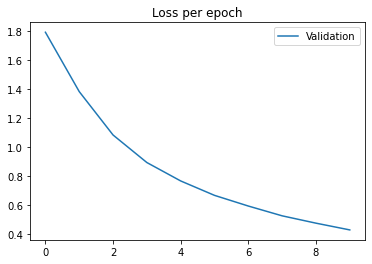

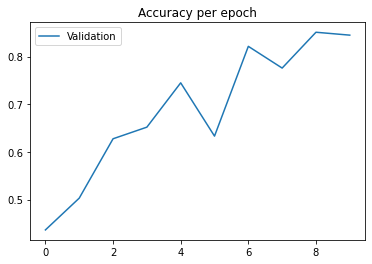

In [30]:
val_acc_history3 = [data.cpu() for data in val_acc_history3]
plot_data(val_acc_history3, loss_acc_history3)

It can be seen that the model can train further, but still the training process is time-consuming, I am stopping at this point. The overall idea of model architecture is grasped.